<a href="https://colab.research.google.com/github/Ansh3931up/DS_Assignment/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/building-sites-power-consumption-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/building-sites-power-consumption-dataset/versions/1


In [5]:
# Load dataset
data = pd.read_csv('/content/power-laws-forecasting-energy-consumption-training-data.csv')
data.head()


,obs_id;SiteId;Timestamp;ForecastId;Value
0,4852050;42;2016-10-18T02:45:00+00:00;1087;2639...
1,1638923;42;2016-10-18T11:45:00+00:00;1087;4295...
2,5748910;42;2016-10-18T20:45:00+00:00;1087;2709...
3,38199;42;2016-10-20T10:45:00+00:00;1087;50211....
4,1338204;42;2016-10-20T18:45:00+00:00;1087;5050...


In [6]:
data.info()  # Overview of data types and any missing values
data.describe()  # Summary statistics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6559830 entries, 0 to 6559829
Data columns (total 1 columns):
 #   Column                                    Dtype 
---  ------                                    ----- 
 0   obs_id;SiteId;Timestamp;ForecastId;Value  object
dtypes: object(1)
memory usage: 50.0+ MB


,obs_id;SiteId;Timestamp;ForecastId;Value
count,6559830
unique,6559830
top,4852050;42;2016-10-18T02:45:00+00:00;1087;2639...
freq,1


In [7]:

data = pd.read_csv('/content/power-laws-forecasting-energy-consumption-training-data.csv', sep=';', header=None, names=['obs_id', 'SiteId', 'Timestamp', 'ForecastId', 'Value'])
print(data.head())


<ipython-input-7-388b082dfb7e>:1: DtypeWarning: Columns (0,1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/power-laws-forecasting-energy-consumption-training-data.csv', sep=';', header=None, names=['obs_id', 'SiteId', 'Timestamp', 'ForecastId', 'Value'])


    obs_id  SiteId                  Timestamp  ForecastId               Value
0   obs_id  SiteId                  Timestamp  ForecastId               Value
1  4852050      42  2016-10-18T02:45:00+00:00        1087  26397.049622843042
2  1638923      42  2016-10-18T11:45:00+00:00        1087  42958.364641002845
3  5748910      42  2016-10-18T20:45:00+00:00        1087   27096.91966586979
4    38199      42  2016-10-20T10:45:00+00:00        1087  50211.408086906886


In [8]:
print(data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6559831 entries, 0 to 6559830
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   obs_id      object
 1   SiteId      object
 2   Timestamp   object
 3   ForecastId  object
 4   Value       object
dtypes: object(5)
memory usage: 250.2+ MB
None


In [9]:
# Display the first few rows
print(data.head(10))


    obs_id  SiteId                  Timestamp  ForecastId               Value
0   obs_id  SiteId                  Timestamp  ForecastId               Value
1  4852050      42  2016-10-18T02:45:00+00:00        1087  26397.049622843042
2  1638923      42  2016-10-18T11:45:00+00:00        1087  42958.364641002845
3  5748910      42  2016-10-18T20:45:00+00:00        1087   27096.91966586979
4    38199      42  2016-10-20T10:45:00+00:00        1087  50211.408086906886
5  1338204      42  2016-10-20T18:45:00+00:00        1087   50503.30510485219
6   369980      42  2016-10-21T12:45:00+00:00        1087  51052.959138643935
7  2261640      42  2016-10-23T11:45:00+00:00        1087   52669.48823802522
8  2750701      42  2016-10-25T04:45:00+00:00        1087   24661.03051611572
9  2228603      42  2016-10-26T01:45:00+00:00        1087  26748.691644461356


In [10]:
# Drop the first row if it's a duplicate header
data = data.drop(0).reset_index(drop=True)


In [11]:
# Convert 'Timestamp' to datetime and 'Value' to float
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')



In [12]:
# Drop rows with NaT in 'Timestamp' or NaN in 'Value'
data = data.dropna(subset=['Timestamp', 'Value'])


In [13]:
print(data.info())
print(data.head())



<class 'pandas.core.frame.DataFrame'>
Index: 6473229 entries, 0 to 6559829
Data columns (total 5 columns):
 #   Column      Dtype              
---  ------      -----              
 0   obs_id      object             
 1   SiteId      object             
 2   Timestamp   datetime64[ns, UTC]
 3   ForecastId  object             
 4   Value       float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 296.3+ MB
None
    obs_id SiteId                 Timestamp ForecastId         Value
0  4852050     42 2016-10-18 02:45:00+00:00       1087  26397.049623
1  1638923     42 2016-10-18 11:45:00+00:00       1087  42958.364641
2  5748910     42 2016-10-18 20:45:00+00:00       1087  27096.919666
3    38199     42 2016-10-20 10:45:00+00:00       1087  50211.408087
4  1338204     42 2016-10-20 18:45:00+00:00       1087  50503.305105


In [14]:
# Extract additional time-related features from Timestamp
data['hour'] = data['Timestamp'].dt.hour
data['day'] = data['Timestamp'].dt.day
data['month'] = data['Timestamp'].dt.month
data['dayofweek'] = data['Timestamp'].dt.dayofweek


In [16]:

# Calculate the mean of the target column (replace 'target_column' with the actual name)
average_target_value = data['Value'].mean()

print("Average Target Value:", average_target_value)


Average Target Value: 356010.41390124883


In [16]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data[['hour', 'day', 'month', 'dayofweek']]
y = data['Value']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
161831/161831 ━━━━━━━━━━━━━━━━━━━━ 338s 2ms/step - loss: 449938506186227712.0000 - mae: 1035388.5625 - val_loss: 791426498560.0000 - val_mae: 154508.7969
Epoch 2/10
161831/161831 ━━━━━━━━━━━━━━━━━━━━ 432s 2ms/step - loss: 126350713713328128.0000 - mae: 417311.4062 - val_loss: 788045824000.0000 - val_mae: 159789.4844
Epoch 3/10
161831/161831 ━━━━━━━━━━━━━━━━━━━━ 413s 2ms/step - loss: 157582899846053888.0000 - mae: 464537.3750 - val_loss: 787675152384.0000 - val_mae: 161315.1562
Epoch 4/10
161831/161831 ━━━━━━━━━━━━━━━━━━━━ 372s 2ms/step - loss: 101738798760591360.0000 - mae: 453530.0625 - val_loss: 787596378112.0000 - val_mae: 158323.0781
Epoch 5/10
161831/161831 ━━━━━━━━━━━━━━━━━━━━ 395s 2ms/step - loss: 165493250352742400.0000 - mae: 500863.5938 - val_loss: 787657129984.0000 - val_mae: 175332.1719
Epoch 6/10
161831/161831 ━━━━━━━━━━━━━━━━━━━━ 377s 2ms/step - loss: 342827347583434752.0000 - mae: 876589.9375 - val_loss: 787386400768.0000 - val_mae: 162671.3125
Epoch 7/10
1618

In [18]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error: {mae}')


40458/40458 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 794500726784.0000 - mae: 171014.6875
Mean Absolute Error: 170484.890625



**Model Accuracy Calculation**

**Given:**
- **Mean Absolute Error (MAE):** 170,484.89
- **Average Target Value:** 356,010.41

**Steps to Calculate Accuracy:**

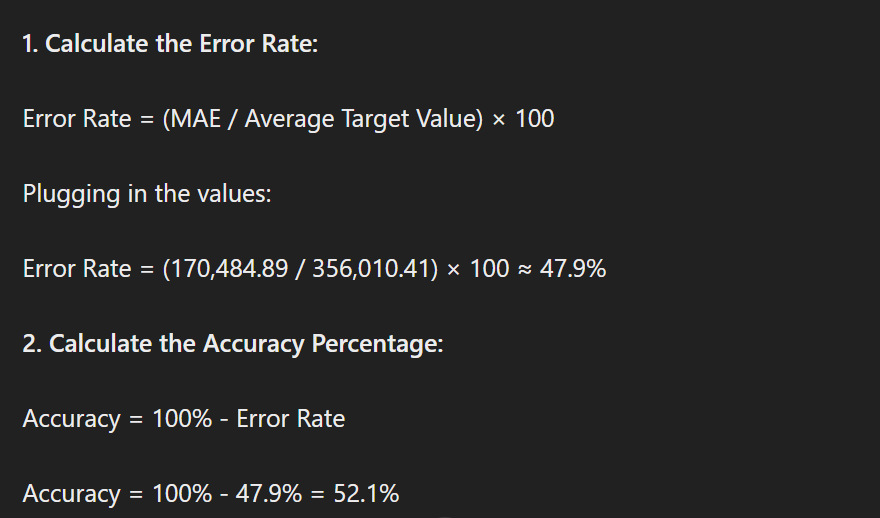
**Result:**
- **Model Accuracy:** ≈ 52.1%

**Interpretation:**
An accuracy of approximately **52.1%** indicates that, on average, the model's predictions are within **52.1%** of the actual target values.
